In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import imageio


start_date = "1948-01-01"
end_date = "2022-06-01"

In [2]:
defense_ticks = ["RTX", "LMT", "BA", "NOC", "GD"]
airline_ticks = ["LUV", "DAL", "UAL", "AAL"]
market_ticks = ["^GSPC", "^DJI", "^IXIC"]
market_labels = ["S&P 500", "DJIA", "NASDAQ Comp."]
commodities_ticks = ["CL=F"]
commodities_labels = ["Crude - June"]

In [3]:
def normalize_price(df):
    min_p = df.min()
    max_p = df.max()
    x = df
    y = (x - min_p) / (max_p - min_p)
    return y

def get_data(ticker_str_list, start_date, end_date):
    tickers = [yf.Ticker(name) for name in ticker_str_list]
    securities = [ticker.history(start = start_date, end = end_date) for ticker in tickers]
    opens = [normalize_price(securs["Open"]) for securs in securities]
    closes = [normalize_price(securs["Close"]) for securs in securities]
    highs = [normalize_price(securs["High"]) for securs in securities]
    lows = [normalize_price(securs["Low"]) for securs in securities]
    volumes = [normalize_price(securs["Volume"]) for securs in securities]

    return opens, closes, highs, lows, volumes

def get_single_data(ticker_str):#, start_date = "2000-01-01", end_date = "2022-05-01"):
    ticker = yf.Ticker(ticker_str)
    df = ticker.history(start = start_date, end = end_date)
    
    return(df)

def get_unnormed_data(ticker_str_list):#, start_date = "2000-01-01", end_date = "2022-05-01"):
    tickers = [yf.Ticker(name) for name in ticker_str_list]
    securities = [ticker.history(start = start_date, end = end_date) for ticker in tickers]
    opens = [securs["Open"] for securs in securities]
    closes = [securs["Close"] for securs in securities]
    highs = [securs["High"] for securs in securities]
    lows = [securs["Low"] for securs in securities]
    volumes = [securs["Volume"] for securs in securities]

    return opens, closes, highs, lows, volumes

def get_mean(data):
    n = len(data[0])
    tot = data[0][0]
    for i in range(1,n):
        tot+= data[0][i]
    return tot/n

In [4]:
def get_unnormed_opens(ticker_str_list, start_date, end_date):
    tickers = [yf.Ticker(name) for name in ticker_str_list]
    securities = [ticker.history(start = start_date, end = end_date) for ticker in tickers]
    opens = [securs["Open"] for securs in securities]

    return opens

In [5]:
sap = pd.read_csv(r'cursp500v2.csv')
sap = sap.fillna(0)

In [6]:
'''
Grab all tickers from each GICS Sub-Industry and group them, along with a list of the GICS Sub-Indistry labels
'''

sub_ind_ticks = []
current_list = []
sub_ind_labels = []
csv_title = "GICS-Sub-Industries.csv"
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y")

with open(csv_title, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Sub-Industry", "Ticker List", " ", "Updated on: {}".format(dt_string)])

    
    for index, row in sap.iterrows():
        if row["Shared GICS Sub-Ind."] == 0:
            current_list.append(row["Symbol"])
        else:
            current_list.append(row["Symbol"])
            sub_ind_ticks.append(current_list)
            sub_ind_labels.append(row["Shared GICS Sub-Ind."])
            writer.writerow([row["Shared GICS Sub-Ind."], current_list])
            current_list = []
        
'''
Index 69 -> Aero & Defense
Index 71 -> Air Frieght & Logistics
Index 72 -> Airlines
''';

In [7]:
dataframes = []
for sub_industry, label in tqdm(zip(sub_ind_ticks, sub_ind_labels)):
    new_frame = pd.DataFrame()
    for entity in sub_industry:
        new_frame[entity] = get_unnormed_opens([entity], start_date, end_date)[0]
    dataframes.append(new_frame)

In [8]:
dataframes_w_avg = []
for subindustry in dataframes:
    hold = pd.DataFrame()
    hold["Normed Mean"] = normalize_price(subindustry).mean(axis=1)
    hold["Mean"] = subindustry.mean(axis=1)
    dataframes_w_avg.append(pd.concat([subindustry, hold], axis = 1))

In [9]:
inflation = pd.read_csv('fredgraph.csv', index_col  = 0)
inflation = inflation.rename(columns={"CPIAUCSL_PC1": "CPI"})#, "CPILFESL_PC1": "CPI Less F&E"})
inflation["CPI"]
corrdata = inflation["CPI"]
corrdata

DATE
1948-01-01    10.24209
1948-02-01     9.48196
1948-03-01     6.81818
1948-04-01     8.27273
1948-05-01     9.38497
                ...   
2021-12-01     7.09654
2022-01-01     7.52593
2022-02-01     7.91202
2022-03-01     8.55759
2022-04-01     8.22414
Name: CPI, Length: 892, dtype: float64

In [10]:
correlations = [corrdata.corr(dataframes_w_avg[x]["Mean"]) for x in range(len(dataframes_w_avg))]
normed_correlations = [corrdata.corr(dataframes_w_avg[x]["Normed Mean"]) for x in range(len(dataframes_w_avg))]

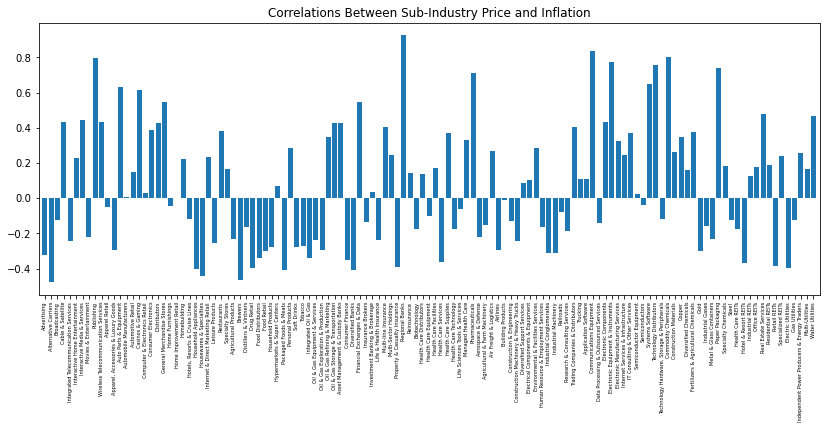

In [11]:
fig, ax1 = plt.subplots(figsize = (14, 5))
ax1.bar(sub_ind_labels, correlations)
ax1.set_xticks(ax1.get_xticks());
ax1.set_xticklabels(sub_ind_labels, rotation = 90, fontsize = 5);
ax1.set_xlim(-1, 123);
ax1.set_title("Correlations Between Sub-Industry Price and Inflation")
fig.savefig("plots/Inflation/All_Sub_Industry_Bar_Chart", dpi = 300, facecolor = 'white', bbox_inches='tight')

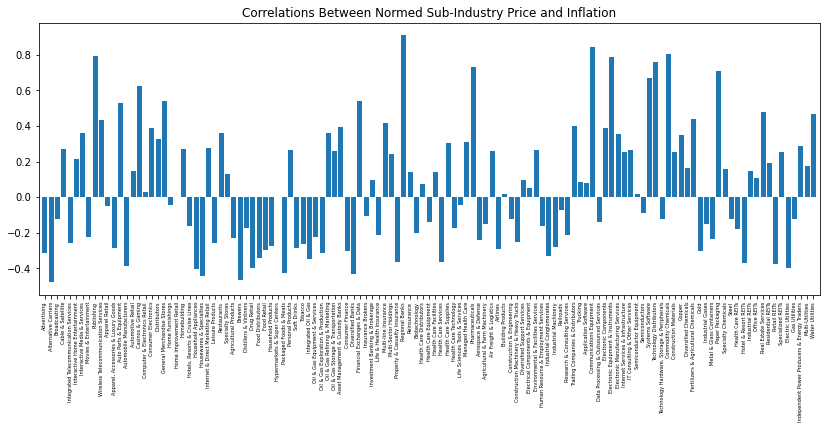

In [12]:
fig, ax1 = plt.subplots(figsize = (14, 5))
ax1.bar(sub_ind_labels, normed_correlations)
ax1.set_xticks(ax1.get_xticks());
ax1.set_xticklabels(sub_ind_labels, rotation = 90, fontsize = 5);
ax1.set_xlim(-1, 123);
ax1.set_title("Correlations Between Normed Sub-Industry Price and Inflation")
fig.savefig("plots/Inflation/All_Sub_Industry_Bar_Chart-Normed", dpi = 300, facecolor = 'white', bbox_inches='tight')

In [13]:
corr_df = {"Subindustry":sub_ind_labels, "Correlation":correlations}
corr_df = pd.DataFrame(corr_df)
corr_df = corr_df.sort_values("Correlation", ascending = False)

normed_corr_df = {"Subindustry":sub_ind_labels, "Correlation":normed_correlations}
normed_corr_df = pd.DataFrame(normed_corr_df)
normed_corr_df = normed_corr_df.sort_values("Correlation", ascending = False)

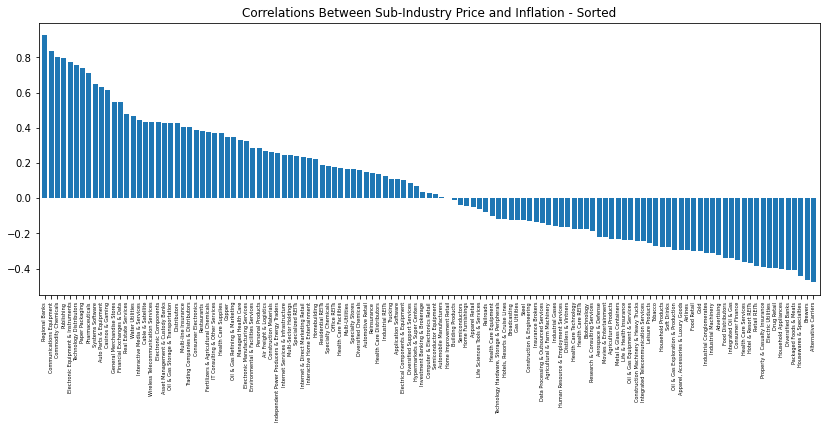

In [14]:
fig, ax1 = plt.subplots(figsize = (14, 5))
ax1.bar(corr_df["Subindustry"], corr_df["Correlation"])
ax1.set_xticks(ax1.get_xticks());
ax1.set_xticklabels(corr_df["Subindustry"], rotation = 90, fontsize = 5);
ax1.set_xlim(-1, 123);
ax1.set_title("Correlations Between Sub-Industry Price and Inflation - Sorted")
fig.savefig("plots/Inflation/All_Sub_Industry_Bar_Chart-Sorted", dpi = 300, facecolor = 'white', bbox_inches='tight')

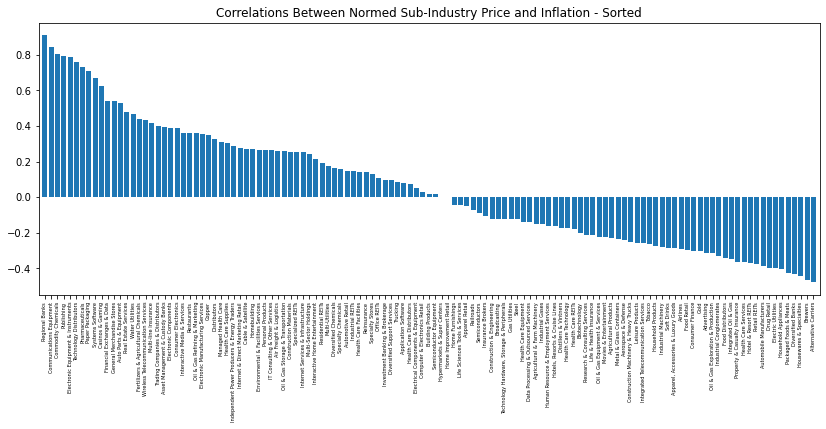

In [15]:
fig, ax1 = plt.subplots(figsize = (14, 5))
ax1.bar(normed_corr_df["Subindustry"], normed_corr_df["Correlation"])
ax1.set_xticks(ax1.get_xticks());
ax1.set_xticklabels(normed_corr_df["Subindustry"], rotation = 90, fontsize = 5);
ax1.set_xlim(-1, 123);
ax1.set_title("Correlations Between Normed Sub-Industry Price and Inflation - Sorted")
fig.savefig("plots/Inflation/All_Sub_Industry_Bar_Chart-Sorted-Norm", dpi = 300, facecolor = 'white', bbox_inches='tight')

In [16]:
filenames = []
step = 5
for i in range(10):
    if i % 2 == 0:
        for j in range(step):
            filenames.append("plots/Inflation/All_Sub_Industry_Bar_Chart-Sorted.png")
    else:
        for j in range(step):
            filenames.append("plots/Inflation/All_Sub_Industry_Bar_Chart-Sorted-Norm.png")
              

with imageio.get_writer('plots/Inflation/Correlation_Diff.gif', mode='I') as writer:
    for filename in tqdm(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)
        

In [17]:
#Change color based on change in value between normed and un-normed